In [1]:
from typing import List, Tuple, TypeVar, Dict
import numpy as np
from tilsdk.localization import *
import math, pyastar2d

T = TypeVar('T')

def visualise_path(path, map):
    pathmap = map.grid.copy()
    pathmap = pathmap > 0
    pathmap = pathmap.astype("int32")
    gridpath = [map_.real_to_grid(x) if isinstance(x, RealLocation) else x for x in path]
    gridpathx = [x[0] for x in gridpath]
    gridpathy = [x[1] for x in gridpath]
    plt.imshow(pathmap)
    plt.scatter(gridpathx,gridpathy,c=np.arange(len(gridpathx)),cmap='Greys')
    plt.title("Path: White -> start, black -> end")
    plt.show()


class MyPlanner:
    def __init__(self, map_:SignedDistanceGrid=None, waypoint_sparsity=0.5, optimize_threshold=3, consider = 4, biggrid_size=0.5):
        '''
        Parameters
        ----------
        map : SignedDistanceGrid
            Distance grid map
        sdf_weight: float
            Relative weight of distance in cost function.
        waypoint_sparsity: float
            0.5 results in every 50th waypoint being taken at scale=0.01 and 10th at scale=0.05
        consider: float
            For the get_explore function only. See there for more details.
        biggrid_size:
            Divide the grid into squares of side length biggrid_size m.
            When there are no clues, the planner will try to explore every square of this big grid.
        '''
        #ALL grids (including big_grid use [y][x] convention)
        self.optimize_threshold = optimize_threshold
        self.map = map_
        self.bgrid = self.transform_add_border(map_.grid.copy()) #Grid which takes the borders into account
        self.astar_grid = self.transform_for_astar(self.bgrid.copy())
        self.waypoint_sparsity = waypoint_sparsity
        self.biggrid_size = biggrid_size
        self.bg_idim = math.ceil(5/biggrid_size) #i:y
        self.bg_jdim = math.ceil(7/biggrid_size) #j:x
        self.big_grid = [[0 for j in range(self.bg_jdim)] for i in range(self.bg_idim)] #Big_grid stores whether each 0.5*0.5m tile of the arena has been visited
        self.big_grid_centre = [[0 for j in range(self.bg_jdim)] for i in range(self.bg_idim)]
        self.consider = consider
        self.passable = self.map.grid>0
        
        for i in range(self.bg_idim):
            for j in range(self.bg_jdim):
                #Find closest free location to centre of this cell
                y_pos = min(4.9,i*self.biggrid_size+self.biggrid_size/2)
                x_pos = min(6.9,j*self.biggrid_size+self.biggrid_size/2)
                
                grid_loc = self.map.real_to_grid(RealLocation(x_pos,y_pos))
                grid_loc = grid_loc[1],grid_loc[0]
                nc = self.nearest_clear(grid_loc,self.passable)
                #If the closest free location to the entre of the cell is in another cell, 
                #ignore this cell by marking it as visited
                #This doesn't happen though
                nc = nc[1], nc[0]
                nc = self.map.grid_to_real(nc)
                #print("gridctr",RealLocation(x_pos,y_pos),"nc",nc)
                if self.big_grid_of(nc) != (j, i):
                    self.big_grid[i][j] = 1
                else:
                    self.big_grid_centre[i][j]=nc

    def transform_add_border(self, og_grid):
        grid = og_grid.copy()
        a,b = grid.shape
        for i in range(a):
            for j in range(b):
                grid[i][j] = min(grid[i][j],i+1,a-i,j+1,b-j)
        return grid

    def transform_for_astar(self, grid):
        #!-- Possible to edit this transform if u want
        grid2 = grid.copy()
        grid2[grid2>0] = 1 + 1000/(grid2[grid2>0])
        grid2[grid2<=0] = np.inf
        return grid2.astype("float32")

    def big_grid_of(self, l:RealLocation): #Returns the big grid array indices of a real location
        return int(l[0]//self.biggrid_size),int(l[1]//self.biggrid_size)
    
    def visit(self, l: RealLocation):
        indices = self.big_grid_of(l)
        self.big_grid[indices[1]][indices[0]] = max(1,self.big_grid[indices[1]][indices[0]])
        
    def get_explore(self, l:RealLocation, debug:bool = False): #Call this to get a location to go to if there are no locations of interest left
        #debug: Whether to plot maps and show info
        #consider (in __init__): Consider the astar paths of this number of closest unvisited cells by euclidean distance
        #Larger number gives better performance but slower
        m=100
        for i in range(self.bg_idim):
            for j in range(self.bg_jdim):
                m=min(m,self.big_grid[i][j])
        if m == 1: #Can comment out this part if u want the robot to vroom around infinitely
            return None
        
        distance = []
        for i in range(self.bg_idim):
            for j in range(self.bg_jdim):
                if self.big_grid[i][j] == m:
                    distance.append((self.heuristic(self.big_grid_centre[i][j],l),(i,j)))
        distance.sort()
        
        if len(distance) == 0:
            return None
        
        distance = distance[:min(self.consider,len(distance))]
        for i in range(len(distance)):
            loc = self.big_grid_centre[distance[i][1][0]][distance[i][1][1]]
            if debug:
                print("l, loc:",l,loc)
            path = self.plan(l, loc, whole_path=True, display=debug)
            distance[i] = (1e18 if type(path) == type(None) else len(path) , distance[i][1])
            if debug:
                print("Path length:",distance[i][0])
                
        distance.sort()
        if debug:
            print("Closest guys",distance[:min(5,len(distance))])
            
        closest = distance[0]
        self.big_grid[closest[1][0]][closest[1][1]] += 1
        
        if debug:
            plt.imshow(self.big_grid)
            plt.title("Big grid now")
            plt.show()
        return self.big_grid_centre[closest[1][0]][closest[1][1]]

    def heuristic(self, a:GridLocation, b:GridLocation) -> float:
        '''Planning heuristic function.        
        Parameters
        ----------
        a: GridLocation
            Starting location.
        b: GridLocation
            Goal location.
        '''
        return euclidean_distance(a, b)
    
    def nearest_clear(self, loc, passable):
        '''Utility function to find the nearest clear cell to a blocked cell'''
        if not passable[loc]:
            best = (1e18,(-1,-1))
            for i in range(map_.height): #y
                for j in range(map_.width): #x
                    if map_.grid[(i,j)]>0:
                        best = min(best,(self.heuristic(GridLocation(i,j),loc),(i,j)))
            loc = best[1]
        return loc

    def plan(self, start:RealLocation, goal:RealLocation, whole_path:bool = False, display:bool = True) -> List[RealLocation]:
        '''Plan in real coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: RealLocation
            Starting location.
        goal: RealLocation
            Goal location.
        whole_path:
            Whether to return the whole path instead of version with select waypoints
        display:
            Whether to visualise the path
        
        Returns
        -------
        path
            List of RealLocation from start to goal.
        '''

        path = self.plan_grid(self.map.real_to_grid(start), self.map.real_to_grid(goal), whole_path)
        if path is None:
            return path
        if display:
            visualise_path(path, self.map)
        path = [self.map.grid_to_real(wp) for wp in path]
        return path

    def plan_grid(self, start:GridLocation, goal:GridLocation, whole_path:bool = False, debug=False) -> List[GridLocation]:
        '''Plan in grid coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: GridLocation
            Starting location.
        goal: GridLocation
            Goal location.
        whole_path:
            Whether to return the whole path instead of version with select waypoints
        debug:
            Whether to print start and end locations
        Returns
        -------
        path
            List of GridLocation from start to goal.
        '''
        
        
        if not self.map:
            raise RuntimeError('Planner map is not initialized.')
        
        start = start[1],start[0]
        goal = goal[1],goal[0] #Use i=x,j=y convention for convenience
        passable = self.map.grid>0

        if debug:
            print("original start",start)
            print("original goal",goal)
        start = self.nearest_clear(start, passable)
        goal = self.nearest_clear(goal, passable)
        if debug:
            print("start",start)
            print("goal",goal)

        #astar
        path = pyastar2d.astar_path(self.astar_grid, start, goal, allow_diagonal=True)
        if path is None:
            return None
        coeff = int(self.waypoint_sparsity/self.map.scale) # default sparsity 0.5 --> 50 for 0.01, 10 for 0.05
        path = list(path)
        path = [(x[1],x[0]) for x in path]
        if whole_path:
            return path
        coeff = max(coeff ,1)
        path = path[:1] + path[:-1:coeff] + path[-1:] #Take the 1st, last, and every 20th waypoint in the middle
        path.append(path[-1]) #Duplicate last waypoint to avoid bug in main loop
        return self.optimize_path(path)

    def optimize_path(self, path:List[GridLocation]) -> List[GridLocation]:
        new_path = [path[0]]  # starting point always in path
        for i in range(1, len(path)-1, 1):
            if not ((abs(path[i-1][0] - path[i][0]) < self.optimize_threshold and abs(path[i][0] - path[i+1][0]) < self.optimize_threshold) or (abs(path[i-1][1] - path[i][1]) < self.optimize_threshold and abs(path[i][1] - path[i+1][1]) < self.optimize_threshold)):  # 3 consecutive points are on a straight line in either x or y direction
                new_path.append(path[i])
        new_path.append(path[-1])  # add last point
        return new_path

In [43]:
import logging
from typing import List

from tilsdk import *                                            # import the SDK
from tilsdk.utilities import PIDController, SimpleMovingAverage # import optional useful things
from tilsdk.mock_robomaster.robot import Robot                  # Use this for the simulator
# from robomaster.robot import Robot                             # Use this for real robot

# Import your code
#from stubs.cv_service import MockCVService #,CVService
from stubs.nlp_service import NLPService, MockNLPService
from stubs.planner import Planner
import pyastar2d
import copy

In [44]:
# Setup logging in a nice readable format
logging.basicConfig(level=logging.INFO,
                format='[%(levelname)5s][%(asctime)s][%(name)s]: %(message)s',
                datefmt='%H:%M:%S')

# Define config variables in an easily accessible location
# You may consider using a config file
REACHED_THRESHOLD_M = 0.3   # TODO: Participant may tune.
ANGLE_THRESHOLD_DEG = 20.0  # TODO: Participant may tune.
ROBOT_RADIUS_M = 0.17       # TODO: Participant may tune.
NLP_MODEL_DIR = '../model.onnx'          # TODO: Participant to fill in.
NLP_PREPROCESSOR_DIR = '../finals_audio_model/'          # TODO: Participant to fill in.
CV_MODEL_DIR = ''           # TODO: Participant to fill in.

# Convenience function to update locations of interest.
def update_locations(old:List[RealLocation], new:List[RealLocation]) -> None:
    '''Update locations with no duplicates.'''
    if new:
        for loc in new:
            if loc not in old:
                logging.getLogger('update_locations').info('New location of interest: {}'.format(loc))
                old.append(loc)

In [45]:
# Initialize services
# cv_service = CVService(model_dir=CV_MODEL_DIR)

#cv_service = MockCVService(model_dir=CV_MODEL_DIR)

#nlp_service = NLPService(model_dir=NLP_MODEL_DIR, preprocessor_dir=NLP_PREPROCESSOR_DIR)
nlp_service = MockNLPService(model_dir=NLP_MODEL_DIR)

loc_service = LocalizationService(host='localhost', port=5566)

#rep_service = ReportingService(host='localhost', port=5501)
# Start the run
#rep_service.start_run()

robot = Robot()
robot.initialize(conn_type="sta")
robot.camera.start_video_stream(display=False, resolution='720p')

In [46]:
# Initialize planner
map_:SignedDistanceGrid = loc_service.get_map()
map_ = map_.dilated(1.5*ROBOT_RADIUS_M/map_.scale)
planner = MyPlanner(map_, waypoint_sparsity=0.4, optimize_threshold=3, biggrid_size=0.8)

# Initialize variables
seen_clues = set()
curr_loi:RealLocation = None
path:List[RealLocation] = []
lois:List[RealLocation] = []
curr_wp:RealLocation = None

# Initialize pose filter
pose_filter = SimpleMovingAverage(n=10)

# Define filter function to exclude clues seen before   
new_clues = lambda c: c.clue_id not in seen_clues

[WARNING][18:49:57][urllib3.connectionpool]: Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001F30244C700>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /map
[WARNING][18:50:01][urllib3.connectionpool]: Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001F37FEAFE80>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /map


In [47]:
#Tune here
tracker = PIDController(Kp=(0.4, 0.2), Kd=(0.2, 0.1), Ki=(0.0, 0.0)) #first: displacement, second: angle

[ INFO][18:50:36][Main]: No more locations of interest.


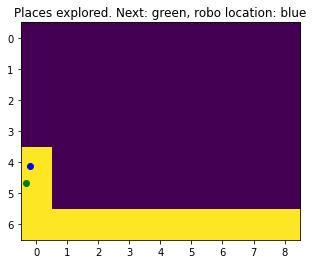

[ INFO][18:50:36][Main]: Current LOI set to: RealLocation(x=0.4, y=4.45)
[ INFO][18:50:36][Main]: Planning path to: RealLocation(x=0.4, y=4.45)


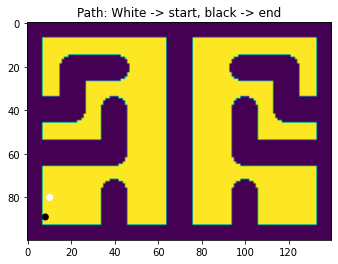

[ INFO][18:50:36][Main]: Path planned.
[ INFO][18:50:36][Navigation]: New waypoint: RealLocation(x=0.5, y=4.0)
[ INFO][18:50:36][Navigation]: Reached wp: RealLocation(x=0.5, y=4.0)
[ INFO][18:50:36][Navigation]: New waypoint: RealLocation(x=0.4, y=4.45)
[ INFO][18:50:36][Navigation]: End of path.
[ INFO][18:50:36][Main]: No more locations of interest.


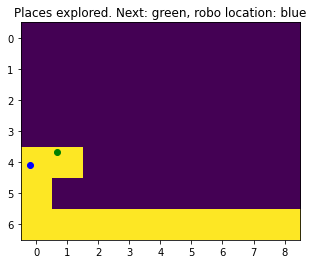

[ INFO][18:50:36][Main]: Current LOI set to: RealLocation(x=1.2000000000000002, y=3.6500000000000004)
[ INFO][18:50:36][Main]: Planning path to: RealLocation(x=1.2000000000000002, y=3.6500000000000004)


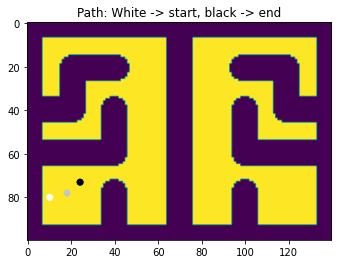

[ INFO][18:50:37][Main]: Path planned.
[ INFO][18:50:37][Navigation]: New waypoint: RealLocation(x=0.5, y=4.0)
[ INFO][18:50:37][Navigation]: Reached wp: RealLocation(x=0.5, y=4.0)
[ INFO][18:50:37][Navigation]: New waypoint: RealLocation(x=0.9, y=3.9000000000000004)
[ INFO][18:50:39][Navigation]: Reached wp: RealLocation(x=0.9, y=3.9000000000000004)
[ INFO][18:50:39][Navigation]: New waypoint: RealLocation(x=1.2000000000000002, y=3.6500000000000004)
[ INFO][18:50:46][Navigation]: Reached wp: RealLocation(x=1.2000000000000002, y=3.6500000000000004)
[ INFO][18:50:46][Navigation]: New waypoint: RealLocation(x=1.2000000000000002, y=3.6500000000000004)
[ INFO][18:50:46][Navigation]: Reached wp: RealLocation(x=1.2000000000000002, y=3.6500000000000004)
[ INFO][18:50:46][Navigation]: End of path.
[ INFO][18:50:46][Main]: No more locations of interest.


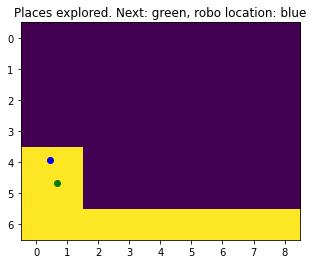

[ INFO][18:50:46][Main]: Current LOI set to: RealLocation(x=1.2000000000000002, y=4.45)
[ INFO][18:50:46][Main]: Planning path to: RealLocation(x=1.2000000000000002, y=4.45)


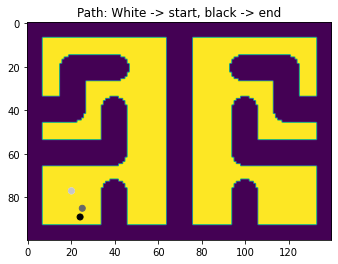

[ INFO][18:50:47][Main]: Path planned.
[ INFO][18:50:47][Navigation]: New waypoint: RealLocation(x=1.0, y=3.85)
[ INFO][18:50:47][Navigation]: Reached wp: RealLocation(x=1.0, y=3.85)
[ INFO][18:50:47][Navigation]: New waypoint: RealLocation(x=1.0, y=3.85)
[ INFO][18:50:47][Navigation]: Reached wp: RealLocation(x=1.0, y=3.85)
[ INFO][18:50:47][Navigation]: New waypoint: RealLocation(x=1.25, y=4.25)
[ INFO][18:50:58][Navigation]: Reached wp: RealLocation(x=1.25, y=4.25)
[ INFO][18:50:58][Navigation]: New waypoint: RealLocation(x=1.2000000000000002, y=4.45)
[ INFO][18:50:58][Navigation]: End of path.
[ INFO][18:50:58][Main]: No more locations of interest.


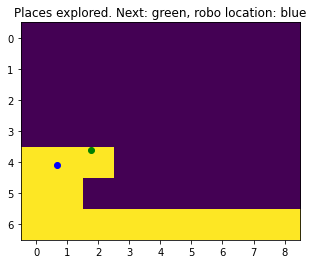

[ INFO][18:50:58][Main]: Current LOI set to: RealLocation(x=2.1, y=3.6)
[ INFO][18:50:58][Main]: Planning path to: RealLocation(x=2.1, y=3.6)


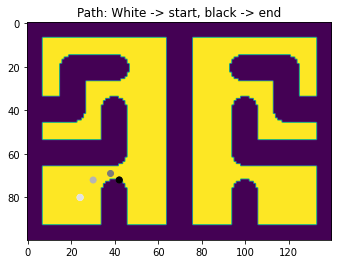

[ INFO][18:50:59][Main]: Path planned.
[ INFO][18:50:59][Navigation]: New waypoint: RealLocation(x=1.2000000000000002, y=4.0)
[ INFO][18:50:59][Navigation]: Reached wp: RealLocation(x=1.2000000000000002, y=4.0)
[ INFO][18:50:59][Navigation]: New waypoint: RealLocation(x=1.2000000000000002, y=4.0)
[ INFO][18:50:59][Navigation]: Reached wp: RealLocation(x=1.2000000000000002, y=4.0)
[ INFO][18:50:59][Navigation]: New waypoint: RealLocation(x=1.5, y=3.6)
[ INFO][18:51:10][Navigation]: Reached wp: RealLocation(x=1.5, y=3.6)
[ INFO][18:51:10][Navigation]: New waypoint: RealLocation(x=1.9000000000000001, y=3.45)
[ INFO][18:51:13][Navigation]: Reached wp: RealLocation(x=1.9000000000000001, y=3.45)
[ INFO][18:51:13][Navigation]: New waypoint: RealLocation(x=2.1, y=3.6)
[ INFO][18:51:19][Navigation]: Reached wp: RealLocation(x=2.1, y=3.6)
[ INFO][18:51:19][Navigation]: New waypoint: RealLocation(x=2.1, y=3.6)
[ INFO][18:51:19][Navigation]: Reached wp: RealLocation(x=2.1, y=3.6)
[ INFO][18:51:19]

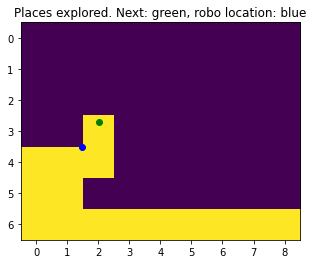

[ INFO][18:51:19][Main]: Current LOI set to: RealLocation(x=2.3000000000000003, y=2.85)
[ INFO][18:51:19][Main]: Planning path to: RealLocation(x=2.3000000000000003, y=2.85)


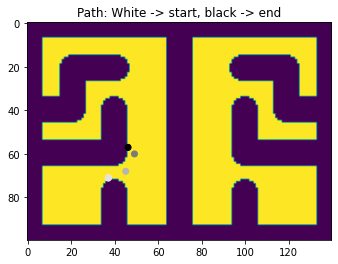

[ INFO][18:51:19][Main]: Path planned.
[ INFO][18:51:20][Navigation]: New waypoint: RealLocation(x=1.85, y=3.5500000000000003)
[ INFO][18:51:20][Navigation]: Reached wp: RealLocation(x=1.85, y=3.5500000000000003)
[ INFO][18:51:20][Navigation]: New waypoint: RealLocation(x=1.85, y=3.5500000000000003)
[ INFO][18:51:20][Navigation]: Reached wp: RealLocation(x=1.85, y=3.5500000000000003)
[ INFO][18:51:20][Navigation]: New waypoint: RealLocation(x=2.25, y=3.4000000000000004)
[ INFO][18:51:21][Navigation]: Reached wp: RealLocation(x=2.25, y=3.4000000000000004)
[ INFO][18:51:21][Navigation]: New waypoint: RealLocation(x=2.45, y=3.0)
[ INFO][18:51:29][Navigation]: Reached wp: RealLocation(x=2.45, y=3.0)
[ INFO][18:51:29][Navigation]: New waypoint: RealLocation(x=2.3000000000000003, y=2.85)
[ INFO][18:51:37][Navigation]: Reached wp: RealLocation(x=2.3000000000000003, y=2.85)
[ INFO][18:51:37][Navigation]: New waypoint: RealLocation(x=2.3000000000000003, y=2.85)
[ INFO][18:51:37][Navigation]: Re

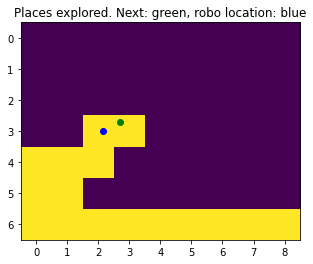

[ INFO][18:51:37][Main]: Current LOI set to: RealLocation(x=2.85, y=2.85)
[ INFO][18:51:37][Main]: Planning path to: RealLocation(x=2.85, y=2.85)


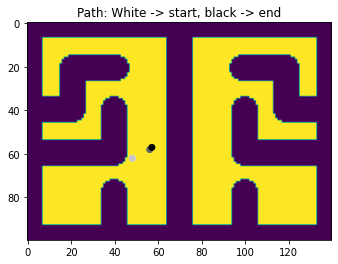

[ INFO][18:51:37][Main]: Path planned.
[ INFO][18:51:37][Navigation]: New waypoint: RealLocation(x=2.4000000000000004, y=3.1)
[ INFO][18:51:37][Navigation]: Reached wp: RealLocation(x=2.4000000000000004, y=3.1)
[ INFO][18:51:38][Navigation]: New waypoint: RealLocation(x=2.4000000000000004, y=3.1)
[ INFO][18:51:38][Navigation]: Reached wp: RealLocation(x=2.4000000000000004, y=3.1)
[ INFO][18:51:38][Navigation]: New waypoint: RealLocation(x=2.8000000000000003, y=2.9000000000000004)
[ INFO][18:51:46][Navigation]: Reached wp: RealLocation(x=2.8000000000000003, y=2.9000000000000004)
[ INFO][18:51:46][Navigation]: New waypoint: RealLocation(x=2.85, y=2.85)
[ INFO][18:51:46][Navigation]: End of path.
[ INFO][18:51:46][Main]: No more locations of interest.


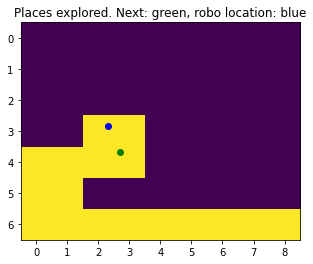

[ INFO][18:51:47][Main]: Current LOI set to: RealLocation(x=2.85, y=3.6500000000000004)
[ INFO][18:51:47][Main]: Planning path to: RealLocation(x=2.85, y=3.6500000000000004)


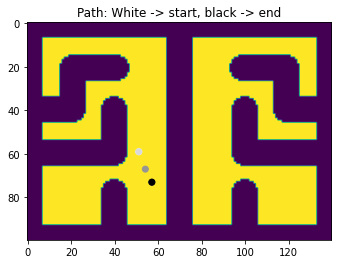

[ INFO][18:51:47][Main]: Path planned.
[ INFO][18:51:47][Navigation]: New waypoint: RealLocation(x=2.5500000000000003, y=2.95)
[ INFO][18:51:47][Navigation]: Reached wp: RealLocation(x=2.5500000000000003, y=2.95)
[ INFO][18:51:47][Navigation]: New waypoint: RealLocation(x=2.5500000000000003, y=2.95)
[ INFO][18:51:47][Navigation]: Reached wp: RealLocation(x=2.5500000000000003, y=2.95)
[ INFO][18:51:47][Navigation]: New waypoint: RealLocation(x=2.7, y=3.35)
[ INFO][18:51:57][Navigation]: Reached wp: RealLocation(x=2.7, y=3.35)
[ INFO][18:51:57][Navigation]: New waypoint: RealLocation(x=2.85, y=3.6500000000000004)
[ INFO][18:51:59][Navigation]: Reached wp: RealLocation(x=2.85, y=3.6500000000000004)
[ INFO][18:51:59][Navigation]: New waypoint: RealLocation(x=2.85, y=3.6500000000000004)
[ INFO][18:51:59][Navigation]: Reached wp: RealLocation(x=2.85, y=3.6500000000000004)
[ INFO][18:51:59][Navigation]: End of path.
[ INFO][18:51:59][Main]: No more locations of interest.


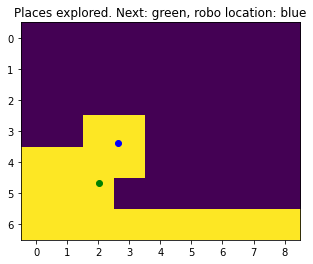

[ INFO][18:52:00][Main]: Current LOI set to: RealLocation(x=2.3000000000000003, y=4.45)
[ INFO][18:52:00][Main]: Planning path to: RealLocation(x=2.3000000000000003, y=4.45)


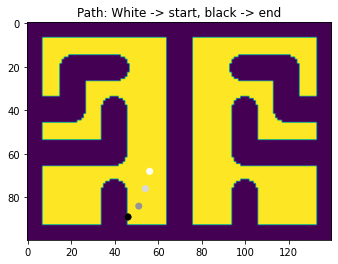

[ INFO][18:52:00][Main]: Path planned.
[ INFO][18:52:00][Navigation]: New waypoint: RealLocation(x=2.8000000000000003, y=3.4000000000000004)
[ INFO][18:52:00][Navigation]: Reached wp: RealLocation(x=2.8000000000000003, y=3.4000000000000004)
[ INFO][18:52:00][Navigation]: New waypoint: RealLocation(x=2.7, y=3.8000000000000003)
[ INFO][18:52:06][Navigation]: Reached wp: RealLocation(x=2.7, y=3.8000000000000003)
[ INFO][18:52:06][Navigation]: New waypoint: RealLocation(x=2.5500000000000003, y=4.2)
[ INFO][18:52:08][Navigation]: Reached wp: RealLocation(x=2.5500000000000003, y=4.2)
[ INFO][18:52:08][Navigation]: New waypoint: RealLocation(x=2.3000000000000003, y=4.45)
[ INFO][18:52:13][Navigation]: Reached wp: RealLocation(x=2.3000000000000003, y=4.45)
[ INFO][18:52:13][Navigation]: New waypoint: RealLocation(x=2.3000000000000003, y=4.45)
[ INFO][18:52:13][Navigation]: Reached wp: RealLocation(x=2.3000000000000003, y=4.45)
[ INFO][18:52:13][Navigation]: End of path.
[ INFO][18:52:13][Main]

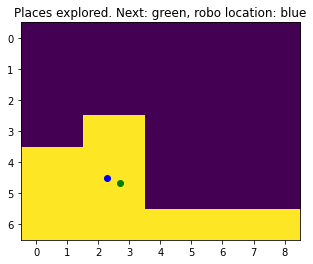

[ INFO][18:52:13][Main]: Current LOI set to: RealLocation(x=2.85, y=4.45)
[ INFO][18:52:13][Main]: Planning path to: RealLocation(x=2.85, y=4.45)


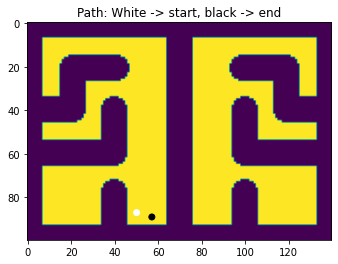

[ INFO][18:52:14][Main]: Path planned.
[ INFO][18:52:14][Navigation]: New waypoint: RealLocation(x=2.5, y=4.3500000000000005)
[ INFO][18:52:14][Navigation]: Reached wp: RealLocation(x=2.5, y=4.3500000000000005)
[ INFO][18:52:14][Navigation]: New waypoint: RealLocation(x=2.85, y=4.45)
[ INFO][18:52:14][Navigation]: End of path.
[ INFO][18:52:14][Main]: No more locations of interest.


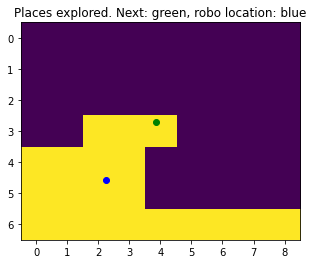

[ INFO][18:52:15][Main]: Current LOI set to: RealLocation(x=3.8000000000000003, y=2.85)
[ INFO][18:52:15][Main]: Planning path to: RealLocation(x=3.8000000000000003, y=2.85)
[ INFO][18:52:15][Main]: No possible path found, location skipped
[ INFO][18:52:15][Main]: No more locations of interest.


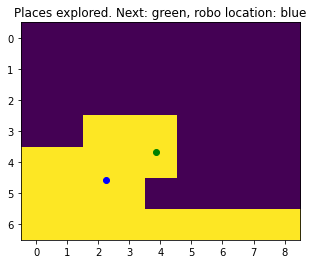

[ INFO][18:52:15][Main]: Current LOI set to: RealLocation(x=3.8000000000000003, y=3.6500000000000004)
[ INFO][18:52:15][Main]: Planning path to: RealLocation(x=3.8000000000000003, y=3.6500000000000004)
[ INFO][18:52:15][Main]: No possible path found, location skipped
[ INFO][18:52:15][Main]: No more locations of interest.


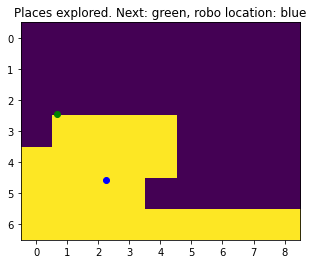

[ INFO][18:52:15][Main]: Current LOI set to: RealLocation(x=1.2000000000000002, y=2.6500000000000004)
[ INFO][18:52:15][Main]: Planning path to: RealLocation(x=1.2000000000000002, y=2.6500000000000004)


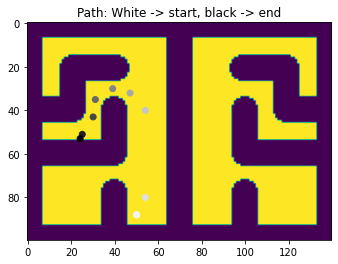

[ INFO][18:52:16][Main]: Path planned.
[ INFO][18:52:16][Navigation]: New waypoint: RealLocation(x=2.5, y=4.4)
[ INFO][18:52:16][Navigation]: Reached wp: RealLocation(x=2.5, y=4.4)
[ INFO][18:52:16][Navigation]: New waypoint: RealLocation(x=2.5, y=4.4)
[ INFO][18:52:16][Navigation]: Reached wp: RealLocation(x=2.5, y=4.4)
[ INFO][18:52:16][Navigation]: New waypoint: RealLocation(x=2.7, y=4.0)
[ INFO][18:52:32][Navigation]: Reached wp: RealLocation(x=2.7, y=4.0)
[ INFO][18:52:32][Navigation]: New waypoint: RealLocation(x=2.7, y=2.0)
[ INFO][18:52:43][Main]: New location(s) of interest: [RealLocation(x=1.0, y=2.5)].
[ INFO][18:52:43][update_locations]: New location of interest: RealLocation(x=1.0, y=2.5)
[ INFO][18:52:46][Navigation]: Reached wp: RealLocation(x=2.7, y=2.0)
[ INFO][18:52:46][Navigation]: New waypoint: RealLocation(x=2.35, y=1.6)
[ INFO][18:52:49][Navigation]: Reached wp: RealLocation(x=2.35, y=1.6)
[ INFO][18:52:49][Navigation]: New waypoint: RealLocation(x=1.9500000000000

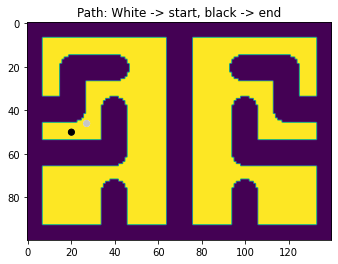

[ INFO][18:53:31][Main]: Path planned.
[ INFO][18:53:31][Navigation]: New waypoint: RealLocation(x=1.35, y=2.3000000000000003)
[ INFO][18:53:31][Navigation]: Reached wp: RealLocation(x=1.35, y=2.3000000000000003)
[ INFO][18:53:31][Navigation]: New waypoint: RealLocation(x=1.35, y=2.3000000000000003)
[ INFO][18:53:31][Navigation]: Reached wp: RealLocation(x=1.35, y=2.3000000000000003)
[ INFO][18:53:31][Navigation]: New waypoint: RealLocation(x=1.0, y=2.5)
[ INFO][18:53:40][Navigation]: Reached wp: RealLocation(x=1.0, y=2.5)
[ INFO][18:53:40][Navigation]: New waypoint: RealLocation(x=1.0, y=2.5)
[ INFO][18:53:40][Navigation]: Reached wp: RealLocation(x=1.0, y=2.5)
[ INFO][18:53:40][Navigation]: End of path.
[ INFO][18:53:40][Main]: No more locations of interest.


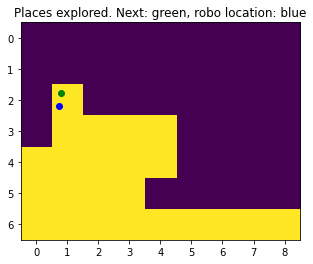

[ INFO][18:53:40][Main]: Current LOI set to: RealLocation(x=1.3, y=2.1)
[ INFO][18:53:40][Main]: Planning path to: RealLocation(x=1.3, y=2.1)


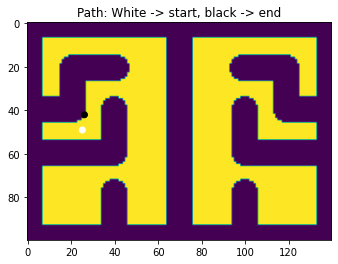

[ INFO][18:53:41][Main]: Path planned.
[ INFO][18:53:41][Navigation]: New waypoint: RealLocation(x=1.25, y=2.45)
[ INFO][18:53:41][Navigation]: Reached wp: RealLocation(x=1.25, y=2.45)
[ INFO][18:53:41][Navigation]: New waypoint: RealLocation(x=1.3, y=2.1)
[ INFO][18:53:41][Navigation]: End of path.
[ INFO][18:53:42][Main]: No more locations of interest.


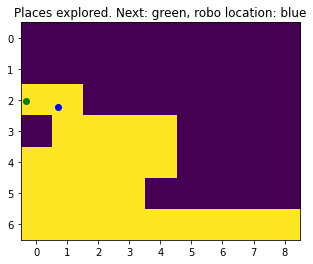

[ INFO][18:53:42][Main]: Current LOI set to: RealLocation(x=0.4, y=2.3000000000000003)
[ INFO][18:53:42][Main]: Planning path to: RealLocation(x=0.4, y=2.3000000000000003)


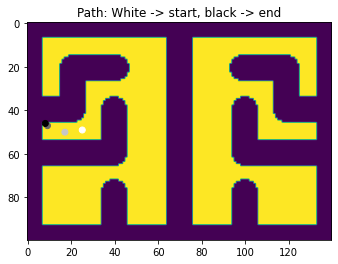

[ INFO][18:53:42][Main]: Path planned.
[ INFO][18:53:42][Navigation]: New waypoint: RealLocation(x=1.25, y=2.45)
[ INFO][18:53:42][Navigation]: Reached wp: RealLocation(x=1.25, y=2.45)
[ INFO][18:53:42][Navigation]: New waypoint: RealLocation(x=0.8500000000000001, y=2.5)
[ INFO][18:54:31][Navigation]: Reached wp: RealLocation(x=0.8500000000000001, y=2.5)
[ INFO][18:54:32][Navigation]: New waypoint: RealLocation(x=0.45, y=2.35)
[ INFO][19:00:40][Navigation]: Reached wp: RealLocation(x=0.45, y=2.35)
[ INFO][19:00:40][Navigation]: New waypoint: RealLocation(x=0.4, y=2.3000000000000003)
[ INFO][19:00:40][Navigation]: End of path.
[ INFO][19:00:40][Main]: No more locations of interest.


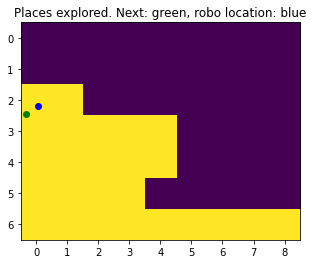

[ INFO][19:00:41][Main]: Current LOI set to: RealLocation(x=0.4, y=2.6500000000000004)
[ INFO][19:00:41][Main]: Planning path to: RealLocation(x=0.4, y=2.6500000000000004)


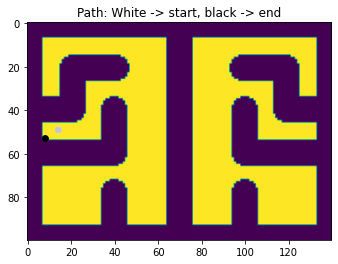

[ INFO][19:00:41][Main]: Path planned.
[ INFO][19:00:41][Navigation]: New waypoint: RealLocation(x=0.7000000000000001, y=2.45)
[ INFO][19:00:41][Navigation]: Reached wp: RealLocation(x=0.7000000000000001, y=2.45)
[ INFO][19:00:41][Navigation]: New waypoint: RealLocation(x=0.7000000000000001, y=2.45)
[ INFO][19:00:41][Navigation]: Reached wp: RealLocation(x=0.7000000000000001, y=2.45)
[ INFO][19:00:41][Navigation]: New waypoint: RealLocation(x=0.4, y=2.6500000000000004)
[WARNING][19:01:12][urllib3.connectionpool]: Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError("Connection broken: ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)", ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))': /camera
[WARNING][19:01:16][urllib3.connectionpool]: Retrying (Retry(total=1, connect=None, read=None, redirect

KeyboardInterrupt: 

In [49]:
# Main loop
while True:
    # Get new data
    pose, clues = loc_service.get_pose()
    pose = pose_filter.update(pose)
    img = robot.camera.read_cv2_image(strategy='newest')
    if not pose:
        # no new data, continue to next iteration.
        continue

    #Set this location as visited in the planner (so no need to visit here again if there are no clues)    
    #planner.visit(pose[:2])
    
    # Filter out clues that were seen before
    clues = filter(new_clues, clues)

    # Process clues using NLP and determine any new locations of interest
    if clues:
        clues=list(clues) #It bugs without this
        new_lois = nlp_service.locations_from_clues(clues) #new locations of interest
        if len(new_lois):
            logging.getLogger('Main').info('New location(s) of interest: {}.'.format(new_lois))
        update_locations(lois, new_lois)
        seen_clues.update([c.clue_id for c in clues])

    """    # Process image and detect targets
    targets = cv_service.targets_from_image(img)

    # Submit targets
    if targets:
        logging.getLogger('Main').info('{} targets detected.'.format(len(targets)))
        #logging.getLogger('Reporting').info(rep_service.report(pose, img, targets))
    """
    if not curr_loi:
        if len(lois) == 0:
            logging.getLogger('Main').info('No more locations of interest.')
            explore_next = planner.get_explore(pose[:2])
            if type(explore_next) == type(None):
                logging.getLogger('Main').info('Whole map explored. Terminating.')
                break
            plt.imshow(planner.big_grid)
            plt.title("Places explored. Next: green, robo location: blue")
            plt.scatter(explore_next[0]/planner.biggrid_size-planner.biggrid_size,explore_next[1]/planner.biggrid_size-planner.biggrid_size,c="green")
            plt.scatter(pose[0]/planner.biggrid_size-planner.biggrid_size,pose[1]/planner.biggrid_size-planner.biggrid_size,c="blue")
            plt.show()
            lois.append(explore_next)
            #break
            
        # Get new LOI
        lois.sort(key=lambda l: euclidean_distance(l, pose), reverse=True)
        curr_loi = lois.pop()
        logging.getLogger('Main').info('Current LOI set to: {}'.format(curr_loi))

        # Plan a path to the new LOI
        logging.getLogger('Main').info('Planning path to: {}'.format(curr_loi))

        path = planner.plan(pose[:2], curr_loi)
        if type(path) == type(None):
            logging.getLogger('Main').info('No possible path found, location skipped')
            #print("lois",lois)
            #print("seen:",seen_clues)
            curr_loi = None
        else:
        #path = [curr_loi,curr_loi]
            path.reverse() # reverse so closest wp is last so that pop() is cheap , waypoint
            curr_wp = None
            logging.getLogger('Main').info('Path planned.')
    else:
        # There is a current LOI objective.
        # Continue with navigation along current path.
        if path:
            # Get next waypoint
            if not curr_wp:
                curr_wp = path.pop()
                logging.getLogger('Navigation').info('New waypoint: {}'.format(curr_wp))

            #logging.getLogger('Navigation').info('Calculating angle')
            # Calculate distance and heading to waypoint
            dist_to_wp = euclidean_distance(pose, curr_wp)
            ang_to_wp = np.degrees(np.arctan2(curr_wp[1]-pose[1], curr_wp[0]-pose[0]))
            ang_diff = -(ang_to_wp - pose[2]) # body frame

            # ensure ang_diff is in [-180, 180]
            if ang_diff < -180:
                ang_diff += 360

            if ang_diff > 180:
                ang_diff -= 360

            #logging.getLogger('Navigation').info('ang_to_wp: {}, hdg: {}, ang_diff: {}'.format(ang_to_wp, pose[2], ang_diff))
            #logging.getLogger('Navigation').info('Pose: {}'.format(pose))
            
            # Consider waypoint reached if within a threshold distance
            logging.getLogger('Navigation').info('End of path.')
            curr_loi = None

            # TODO: Perform search behaviour? Participant to complete.

            continue

robot.chassis.drive_speed(x=0.0, y=0.0, z=0.0)  # set stop for safety
logging.getLogger('Main').info('Mission Terminated.')

# Below: Random working

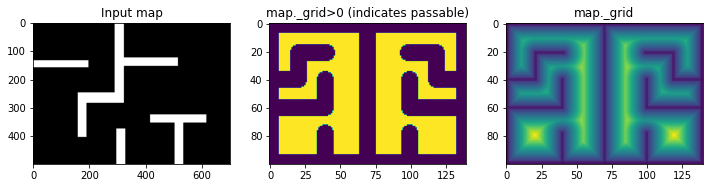

In [8]:
fig, ax = plt.subplots(1,3,figsize=(12,30))
ax[0].imshow(plt.imread("data/maps/map_complex_1cm.png"))
ax[0].title.set_text("Input map")
ax[1].imshow(map_.grid>0)
ax[1].title.set_text("map._grid>0 (indicates passable)")
ax[2].imshow(map_.grid)
ax[2].title.set_text("map._grid")

## Test planner manually

In [36]:
myplanner = MyPlanner(map_, waypoint_sparsity = 1, optimize_threshold=5, biggrid_size=4.99)
#curr_loi = RealLocation(x=1.0, y=2.5)
pose = RealPose(x=0.5, y=4.0, z=0.0)

l, loc: (0.5, 4.0) RealLocation(x=1.55, y=4.6000000000000005)


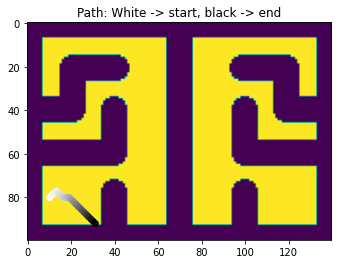

Path length: 22
l, loc: (0.5, 4.0) RealLocation(x=1.55, y=1.55)


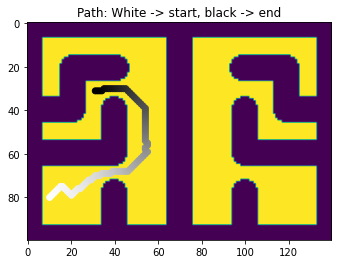

Path length: 89
l, loc: (0.5, 4.0) RealLocation(x=4.65, y=4.6000000000000005)
Path length: 1e+18
l, loc: (0.5, 4.0) RealLocation(x=4.7, y=1.55)
Path length: 1e+18
Closest guys [(22, (1, 0)), (89, (0, 0)), (1e+18, (0, 1)), (1e+18, (1, 1))]


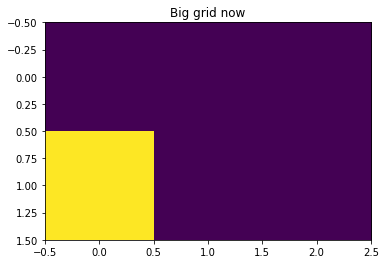

0.522000789642334


In [23]:
import time
start = time.time()
pose = myplanner.get_explore(pose[:2], debug=True)
end = time.time()
print(end - start)


In [24]:
for i in range(50):
    pose = myplanner.get_explore(pose[:2], debug=False)

TypeError: 'NoneType' object is not subscriptable

In [41]:
pose = myplanner.get_explore(pose[:2], debug=False)

In [102]:
myplanner.visit(RealLocation(x=6.92423,y=4.8453489))

In [40]:
myplanner.big_grid

[[1, 1], [1, 1]]

In [31]:
myplanner.big_grid_centre

[[RealLocation(x=2.5, y=2.5), RealLocation(x=6.6000000000000005, y=2.5)],
 [0, 0]]

In [35]:
myplanner.get_explore(pose[:2])

RealLocation(x=2.5, y=2.5)

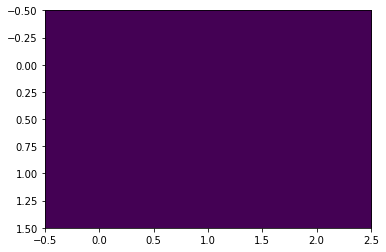

In [28]:
plt.imshow(myplanner.big_grid)
#1 unit = 0.5m, so *2 from the real coordinates
#Plt thinks that box 0,0 represents box -0.5,-0.5 to 0.5,0.5
#But actually it represents 0,0 to 1,1
#For an accurate visualisation, -0.5 (Still quite scammy yes)
#plt.scatter(12,8,c="blue")
#plt.scatter(1*2-0.5,1*2-0.5,c="red")
plt.show()

In [ ]:
import time
start = time.time()
path = None #Needed or path will be taken as a local variable in try
path = myplanner.plan(pose[:2], curr_loi)
end = time.time()
print(end - start)